In [2]:
import pandas as pd
returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)


C:\Users\ayush\AppData\Local\Temp\ipykernel_28992\878252503.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)


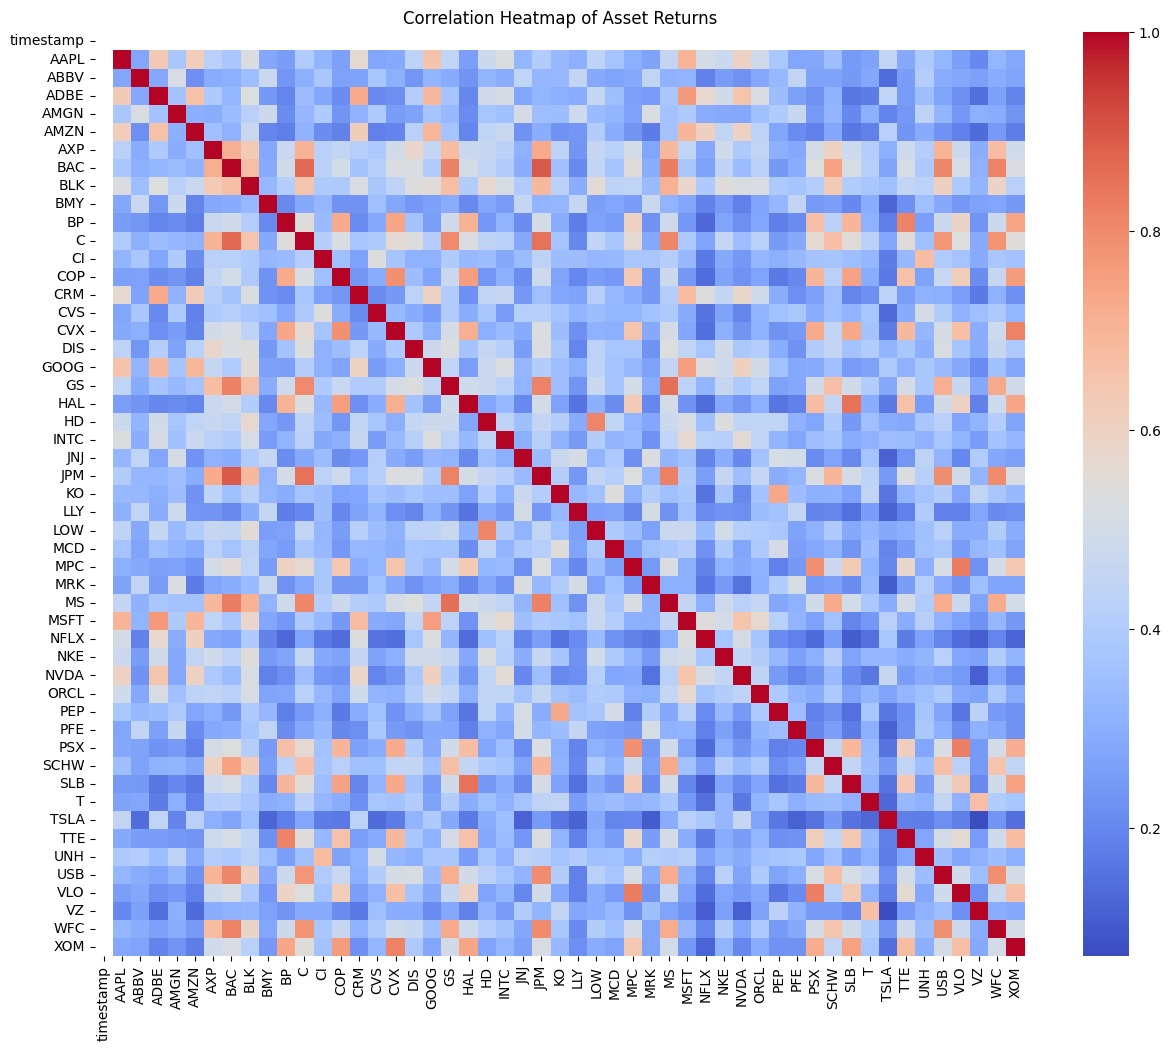

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
returns = returns.apply(pd.to_numeric, errors='coerce')
# Clean the data: remove columns or rows with NaN
returns_clean = returns.dropna(axis=1, how='any')  # drop assets with NaNs
returns_clean = returns_clean.dropna(axis=0, how='any')  # drop dates with NaNs
correlation_matrix = returns.corr()
plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Asset Returns")
plt.show()

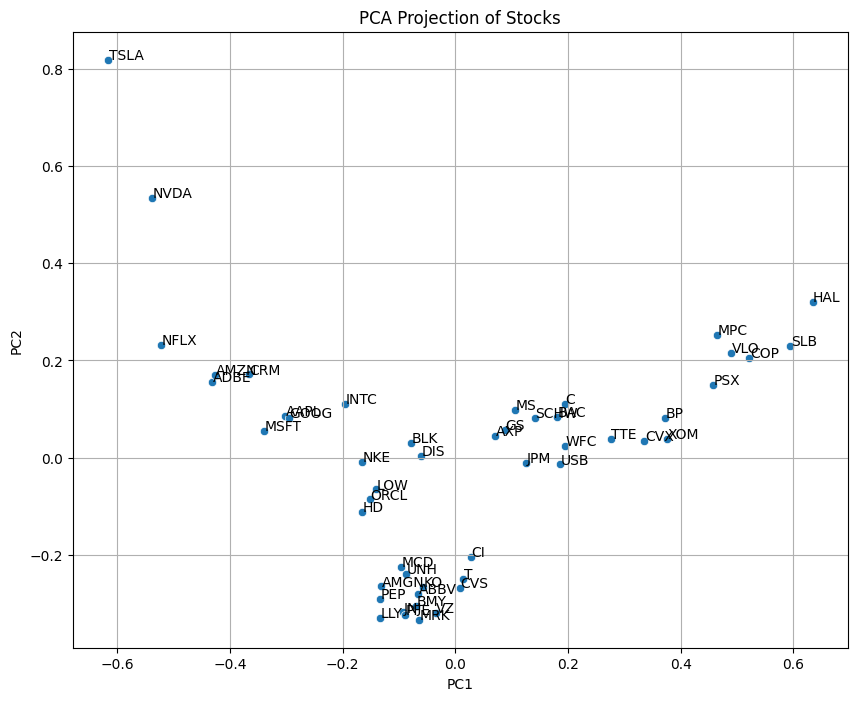

In [9]:
from sklearn.decomposition import PCA

# Run PCA to reduce dimensionality
pca = PCA(n_components=2)
components = pca.fit_transform(returns_clean.T)

# Visualize
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'], index=returns_clean.columns)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
for i in pca_df.index:
    plt.text(pca_df.loc[i, 'PC1']+0.001, pca_df.loc[i, 'PC2']+0.001, i)
plt.title("PCA Projection of Stocks")
plt.grid()
plt.show()

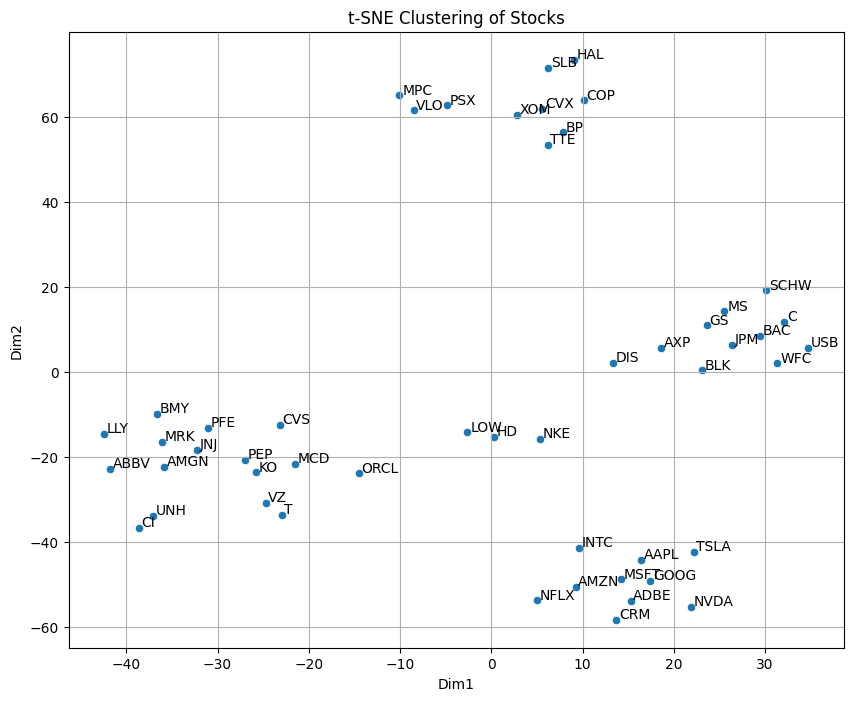

In [10]:
from sklearn.manifold import TSNE

# Reduce dimensionality for clustering visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embedded = tsne.fit_transform(returns_clean.T)

tsne_df = pd.DataFrame(embedded, columns=['Dim1', 'Dim2'], index=returns_clean.columns)
plt.figure(figsize=(10,8))
sns.scatterplot(x='Dim1', y='Dim2', data=tsne_df)
for i in tsne_df.index:
    plt.text(tsne_df.loc[i, 'Dim1']+0.3, tsne_df.loc[i, 'Dim2']+0.3, i)
plt.title("t-SNE Clustering of Stocks")
plt.grid()
plt.show()

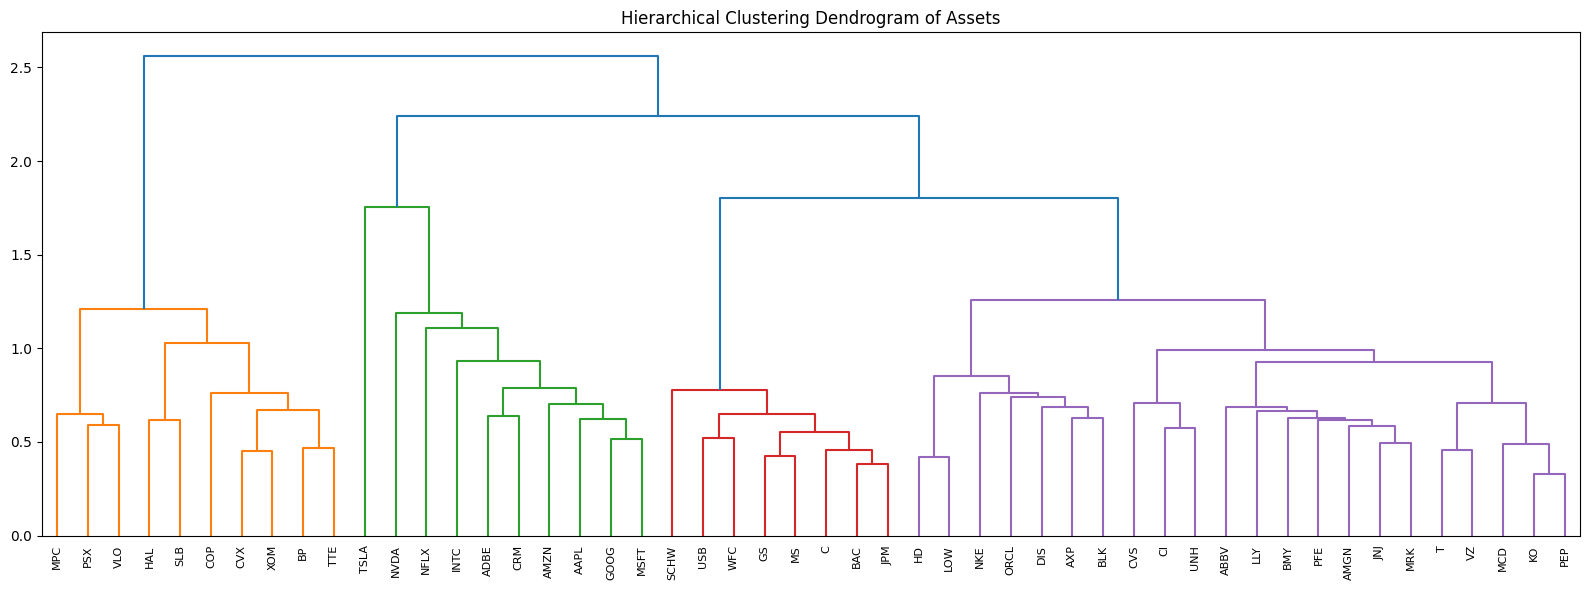

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute linkage matrix and plot dendrogram
linkage_matrix = linkage(returns_clean.T, method='ward')
plt.figure(figsize=(16, 6))
dendrogram(linkage_matrix, labels=returns_clean.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram of Assets")
plt.tight_layout()
plt.show()

In [14]:
#Train a classifier to learn and predict which cluster a stock belongs to based on return patterns.
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Step 1: Run t-SNE again
returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)
returns = returns.apply(pd.to_numeric, errors='coerce')
# Clean the data: remove columns or rows with NaN
returns = returns.dropna(axis=1, how='any')  # drop assets with NaNs
returns = returns_clean.dropna(axis=0, how='any')  # drop dates with NaNs
from sklearn.manifold import TSNE
embedded = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(returns.T)
tsne_df = pd.DataFrame(embedded, columns=['Dim1', 'Dim2'], index=returns.columns)

# Step 2: Cluster stocks using KMeans based on t-SNE output
kmeans = KMeans(n_clusters=4, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(tsne_df[['Dim1', 'Dim2']])

# Step 3: Build a classifier on original return data → predict cluster
X = returns.T  # features: historical returns per stock
y = tsne_df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate classifier
preds = model.predict(X_test)
print(classification_report(y_test, preds))



C:\Users\ayush\AppData\Local\Temp\ipykernel_11308\1545602949.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [15]:
# After creating tsne_df with cluster labels
tsne_df[['Dim1', 'Dim2', 'Cluster']].to_csv("../data/tsne_clusters.csv")
print("✅ t-SNE clusters saved to ../data/tsne_clusters.csv")


✅ t-SNE clusters saved to ../data/tsne_clusters.csv


In [3]:

# Load required data
returns = pd.read_csv("../data/returns.csv", index_col=0, parse_dates=True)
clusters = pd.read_csv("../data/tsne_clusters.csv", index_col=0)
sector_map = pd.read_csv("../data/sector_map.csv", index_col=0)

# Merge cluster and sector info
clusters['Sector'] = sector_map['Sector']
returns_T = returns.T.copy()
returns_T['Cluster'] = clusters['Cluster']

# Calculate average return and volatility per asset
returns_T['Mean Return'] = returns_T.iloc[:, :-1].mean(axis=1)
returns_T['Volatility'] = returns_T.iloc[:, :-2].std(axis=1)

# Merge with cluster info again
returns_T['Sector'] = clusters['Sector']

# Group by cluster
summary = returns_T.groupby('Cluster').agg(
    Num_Stocks=('Mean Return', 'count'),
    Avg_Return=('Mean Return', 'mean'),
    Avg_Volatility=('Volatility', 'mean')
)

# Dominant Sector Calculation
dominant_sector = (
    returns_T.groupby(['Cluster', 'Sector'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Cluster', 'Count'], ascending=[True, False])
)

# Pick top sector per cluster
dominant_sector = dominant_sector.groupby('Cluster').first()
summary['Dominant_Sector'] = dominant_sector['Sector']

# Final formatting
summary = summary.round(4)
print("📊 Cluster Summary Table:")
print(summary)

# Save for dashboard/PowerBI
summary.to_csv("../data/cluster_summary.csv")
print("✅ Saved summary to ../data/cluster_summary.csv")

📊 Cluster Summary Table:
         Num_Stocks  Avg_Return  Avg_Volatility Dominant_Sector
Cluster                                                        
0                12      0.0005          0.0198         Finance
1                18      0.0004          0.0153      Healthcare
2                10      0.0010          0.0271            Tech
3                10      0.0005          0.0236          Energy
✅ Saved summary to ../data/cluster_summary.csv
